In [1]:
%%capture
!pip3 install tensorflow==2.0.0-beta1

# Load the TensorBoard notebook extension
# Restart the jupyter notebook if you just installed TF 2.0 Beta
%reload_ext tensorboard

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import gym
import datetime
from tqdm import tqdm
import logging
import random

In [3]:
!rm -rf ./logs/

# Go Environment
Train on a small board with heuristic reward for fast training and efficient debugging

In [4]:
%%capture
!pip3 install -e gym-go

In [5]:
go_env = gym.make('gym_go:go-v0', size='S', reward_method='real')

In [6]:
BOARD_SIZE = 7

# Machine Learning Models
Deep Q Learning method

In [7]:
from tensorflow.keras import layers

In [8]:
def make_dqn():
    inputs = layers.Input(shape=(BOARD_SIZE, BOARD_SIZE, 4), name="board")
    valid_inputs = layers.Input(shape=(BOARD_SIZE**2 + 1,), name="valid_moves")
    
    x = inputs
    
    x = layers.Conv2D(filters=64, kernel_size=3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    x = layers.Conv2D(filters=64, kernel_size=3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    x = layers.Conv2D(filters=64, kernel_size=3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    x = layers.Conv2D(filters=64, kernel_size=3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    x = layers.Conv2D(filters=1, kernel_size=1)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    x = layers.Flatten()(x)
    
    moves = layers.Dense(50)(x)
    
#     # Dense block
#     num_layers = 8
#     growth_rate = 4
#     x = inputs
#     for i in range(num_layers):
#         y = tf.keras.Sequential([
#             layers.Conv2D(filters=growth_rate, kernel_size=3, padding="same", bias_initializer='ones'),
#             layers.BatchNormalization(),
#             layers.ReLU(),
#         ], name='dense_layer_{}'.format(i))(x)
#         x = layers.Concatenate()([x,y])
    
#     moves = layers.Conv2D(filters=50, kernel_size=BOARD_SIZE, padding="valid", name="all_moves")(x)
    
#     moves = layers.Flatten()(moves)
    
    valid_moves = layers.Multiply(name='moves')([moves, valid_inputs])
    
    model = tf.keras.Model(inputs=[inputs, valid_inputs], outputs=valid_moves, name='DQN')
    return model

In [9]:
dqn = make_dqn()

In [10]:
dqn.summary()

Model: "DQN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
board (InputLayer)              [(None, 7, 7, 4)]    0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 7, 7, 64)     2368        board[0][0]                      
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 7, 7, 64)     256         conv2d[0][0]                     
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 7, 7, 64)     0           batch_normalization[0][0]        
________________________________________________________________________________________________

In [11]:
opponent = tf.keras.models.clone_model(dqn)
target_policy = tf.keras.models.clone_model(dqn)

### Initialization of models 
should be random if the models are fresh

In [12]:
def feed_forward(states, model):
    invalid_moves = states[:,:,:,2].reshape((-1,49))
    invalid_moves = np.insert(invalid_moves, BOARD_SIZE**2, 0, axis=1)
    valid_moves = 1 - invalid_moves
    moves = model([states.astype(np.float32), valid_moves.astype(np.float32)])
    return moves

In [13]:
def get_invalid_values(states):
    """
    Returns the action values of the states where invalid moves have -infinity value (minimum value of float32)
    and valid moves have 0 value
    """
    invalid_moves = states[:,:,:,2].reshape((-1,49))
    invalid_moves = np.insert(invalid_moves, BOARD_SIZE**2, 0, axis=1)
    invalid_values = np.finfo(np.float32).min * invalid_moves
    return invalid_values

In [14]:
def max_action_vals(states, actval_func):
    '''
    The maximum action value (including passing) given the states
    '''
    invalid_values = get_invalid_values(states)
    
    move_vals = feed_forward(states, actval_func)
    max_vals = tf.reduce_max(move_vals + invalid_values, axis=1)
    return max_vals

In [15]:
def argmax_action_vals(states, actval_func):
    """
    Returns the moves that have the maximum values (including passing) given the states
    """
    invalid_values = get_invalid_values(states)
    
    move_vals = feed_forward(states, actval_func)
    argmax_vals = tf.math.argmax(move_vals + invalid_values, axis=1)
    
    return argmax_vals

In [16]:
from sklearn import preprocessing
def state_responses(states, taken_actions=None, next_states=None, rewards=None, terminals=None):
    """
    Returns a figure of plots on the states and the models responses on those states
    """
    state_values = max_action_vals(states, dqn)
    move_values = feed_forward(states, dqn)
    
    if next_states is not None:
        next_move_values = feed_forward(next_states, dqn)
        next_state_values = max_action_vals(next_states, dqn)
    else:
        next_move_values = None
        next_state_values = None
        
    num_states = states.shape[0]
    num_cols = 2 if next_states is None else 4
    
    fig = plt.figure(figsize=(num_cols * 3, num_states * 3))
    for i in range(num_states):
        plt.subplot(num_states,num_cols,1 + num_cols*i)
        plt.axis('off')
        plt.title('Board')
        plt.imshow(states[i][:,:,[0,1,3]].astype(np.float))

        plt.subplot(num_states,num_cols,2 + num_cols*i)
        plt.axis('off')
        plt.title('DQN {:.2f}S\n{:.2f}L {:.2f}H {:.2f}P'
                  .format(state_values[i], np.min(move_values[i][:-1]), 
                          np.max(move_values[i][:-1]), move_values[i][-1]))
        plt.imshow(tf.reshape(move_values[i][:-1], (BOARD_SIZE, BOARD_SIZE)))
        
        if next_states is not None:
            assert taken_actions is not None and len(taken_actions) == len(next_states)
            if i < next_states.shape[0]:
                plt.subplot(num_states,num_cols, 3 + num_cols*i)
                plt.axis('off')
                plt.title('Taken Action: {}\n{}R {}T'.format(taken_actions[i], rewards[i], terminals[i]))
                plt.imshow(next_states[i][:,:,[0,1,3]].astype(np.float))
                
                plt.subplot(num_states,num_cols,4 + num_cols*i)
                plt.axis('off')
                plt.title('DQN {:.2f}S\n{:.2f}L {:.2f}H {:.2f}P'
                          .format(next_state_values[i], np.min(next_move_values[i][:-1]), 
                                  np.max(next_move_values[i][:-1]), next_move_values[i][-1]))
                plt.imshow(tf.reshape(next_move_values[i][:-1], (BOARD_SIZE, BOARD_SIZE)))

    plt.tight_layout()
    return fig

In [17]:
state = go_env.reset()
start_state = np.copy(state)
state, reward, done, info = go_env.step((3,5))
state, reward, done, info = go_env.step((5,3))

In [18]:
states = state.transpose(1,2,0).reshape(1, BOARD_SIZE, BOARD_SIZE, 4)

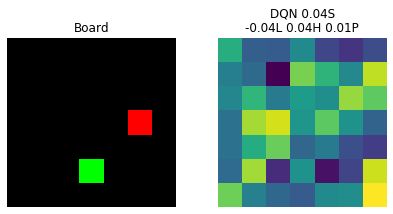

In [19]:
plt.show(state_responses(states))

# Training Setup

### Hyperparameters

In [20]:
NUM_EPISODES = 2000
BATCH_SIZE = 256
MAX_STEPS = 2 * BOARD_SIZE**2
REPLAY_MEM_SIZE = 2e4

LEARNING_RATE = 1e-3
OPPONENT_UPDATE = 200

EPSILON = 1
EPSILON_DECAY = 0.995
EPSILON_MIN = 0.1

GAMMA = 0.90
TARGET_UPDATE = 1 # number of episodes to update the target critic model

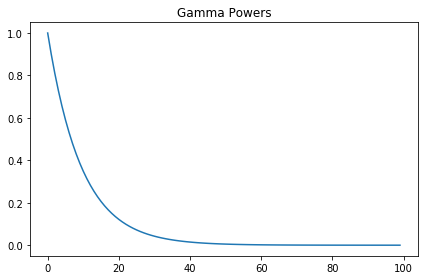

In [21]:
plt.plot([GAMMA**x for x in range(100)])
plt.title("Gamma Powers")
plt.tight_layout()

In [22]:
from collections import deque

In [23]:
replay_mem = deque(maxlen=int(REPLAY_MEM_SIZE))

### Metrics and Tensorboard

Metrics

In [24]:
metrics = {}
for metric_key in ['loss', 'win_percentage']:
    metrics[metric_key] = tf.keras.metrics.Mean('dqn_{}'.format(metric_key), dtype=tf.float32)

Tensorboard

In [25]:
summary_writers = {}
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
for summary_key in ['train', 'test']:
    log_dir = 'logs/dqn/{}/{}'.format(current_time, summary_key)
    summary_writers[summary_key] = tf.summary.create_file_writer(log_dir)

In [26]:
import io
def plot_to_image(figure):
    """Converts the matplotlib plot specified by 'figure' to a PNG image and
    returns it. The supplied figure is closed and inaccessible after this call."""
    # Save the plot to a PNG in memory.
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    # Closing the figure prevents it from being displayed directly inside
    # the notebook.
    plt.close(figure)
    buf.seek(0)
    # Convert PNG buffer to TF image
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    # Add the batch dimension
    image = tf.expand_dims(image, 0)
    return image

### Functions

In [27]:
def convert_1d_to_2d(action_1d):
    if action_1d == BOARD_SIZE**2:
        action = None
    else:
        action = (action_1d // BOARD_SIZE, action_1d % BOARD_SIZE)
    return action

In [28]:
def random_weighted_action(move_weights):
    """
    Assumes all invalid moves have weight 0
    """
    move_weights = preprocessing.normalize(move_weights, norm='l1')

    if np.sum(move_weights) <= 0:
        # Pass
        return None
    
    action_1d = np.random.choice(np.arange(BOARD_SIZE**2 + 1), p=move_weights[0])
    return convert_1d_to_2d(action_1d)

In [29]:
def random_action(state):
    """
    Assumed to be (BOARD_SIZE, BOARD_SIZE, 4)
    """
    invalid_moves = state[:,:,2].reshape((1,-1))
    invalid_moves = np.insert(invalid_moves, BOARD_SIZE**2, 0, axis=1)
    move_weights = 1 - invalid_moves

    action = random_weighted_action(move_weights)
    
    return action

In [30]:
def get_action(policy, state, epsilon):
    """
    Gets an action based on exploration/exploitation
    """
    if state.shape[0] == 4:
        # State shape will be (BOARD_SIZE, BOARD_SIZE, 4)
        state = state.transpose(1,2,0)
            
    epsilon_choice = np.random.uniform()
    if epsilon_choice < epsilon:
        # Random move
        logging.debug("Exploring a random move")
        action = random_action(state)
        
    else:
        # policy makes a move
        logging.debug("Exploiting policy's move")
        reshaped_state = state.reshape(1, BOARD_SIZE, BOARD_SIZE, 4).astype(np.float32)
        
        flattened_actions = argmax_action_vals(reshaped_state, policy)
        action_1d = actions[0]
        action = convert_1d_to_2d(action_1d)
        
    return action

In [31]:
def get_value_for_action(move_values, actions):
    '''
    Get value from board_values based on action, or take the passing_values if the action is None
    '''
    action_values = tf.gather_nd(move_values, [(i, a[0] * BOARD_SIZE + a[1]) if a is not None 
                                                    else (i, BOARD_SIZE**2) 
                                                    for i, a in enumerate(actions)])
    return action_values

In [32]:
def get_batch_obs(size=BATCH_SIZE):
    '''
    Get a batch of orig_states, actions, states, rewards, terminals as np array out of replay memory
    '''
    
    # States were (BATCH_SIZE, 4, BOARD_SIZE, BOARD_SIZE)
    # Convert them to (BATCH_SIZE, BOARD_SIZE, BOARD_SIZE, 4)
    batch = random.sample(replay_mem, size)
    batch = list(zip(*batch))
    orig_states = np.array(list(batch[0]), dtype=np.float32).transpose(0,2,3,1)
    actions = np.array(list(batch[1]))
    states = np.array(list(batch[2]), dtype=np.float32).transpose(0,2,3,1)
    rewards = np.array(list(batch[3]), dtype=np.float32)
    terminals = np.array(list(batch[4]), dtype=np.uint8)
    
    return orig_states, actions, states, rewards, terminals
    

In [33]:
def sample_heatmaps():
    num_samples = 3
    states, actions, next_states, rewards, terminals = get_batch_obs(num_samples)
    states = np.concatenate([states, start_state.transpose(1,2,0)
                             .reshape((-1,BOARD_SIZE, BOARD_SIZE, 4))], axis=0)
    fig = state_responses(states, actions, next_states, rewards, terminals)
    return fig

In [34]:
mean_squared_error = tf.keras.losses.MeanSquaredError(reduction=tf.losses.Reduction.SUM)

In [35]:
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
def update_dqn():
    """
    Optimizes the critic in one step and updates the critic loss metric
    """
    states, actions, next_states, rewards, terminals = get_batch_obs()
    
    # get values for next state
    next_state_vals = max_action_vals(next_states, target_policy)
    
    batch_size = states.shape[0]
    
    with tf.GradientTape() as tape:
        move_vals = feed_forward(states, dqn)
        action_vals = get_value_for_action(move_vals, actions)
        val_loss = mean_squared_error(rewards + GAMMA * next_state_vals * (1-terminals), action_vals) / batch_size
    
    metrics['loss'](val_loss)
    
    # compute and apply gradients
    gradients = tape.gradient(val_loss, dqn.trainable_variables)
    optimizer.apply_gradients(zip(gradients, dqn.trainable_variables))

In [36]:
def play_a_game(episode, train, opponent_epsilon=0):
    """
    Plays out a game, and iteratively updates the models at each step
    Returns the number of moves by the end of the game and the list 
    of rewards after every turn by the black player
    """
    global EPSILON
    
    # Basic setup
    done = False
    num_of_turns = 0
    state = go_env.reset()
    rewards = []
    
    while not done and num_of_turns <= MAX_STEPS:
        # Copy state for memory
        orig_state = np.copy(state)
        
        black_action = get_action(dqn, state, EPSILON)
        if black_action is None:
            logging.debug("Black (actor) passed")
            
        state, reward, done, info = go_env.step(black_action)
        num_of_turns += 1
        rewards.append(reward)
        
        # Update the critic and then actor if we are training and have enough events
        if train and len(replay_mem) >= BATCH_SIZE:
            update_dqn()        
    
            # Update exploration/exploitation
            if EPSILON > EPSILON_MIN:
                EPSILON *= EPSILON_DECAY
                logging.debug("Epsilon decayed to {}".format(EPSILON))
            
        if done:
            # Add to memory if training
            if train:
                replay_mem.append((orig_state, black_action, np.copy(state), reward, done))
            break
            
        # opponent makes a move
        # swap the black and white layers
        temp = np.copy(state[0])
        state[0] = state[1]
        state[1] = temp
        # get action from opponent
        white_action = get_action(None, state, epsilon=opponent_epsilon)
        if white_action is None:
            logging.debug("White (opponent) passed")

        state, reward, done, info = go_env.step(white_action)
        
        # Add to memory if training
        if train:
            replay_mem.append((orig_state, black_action, np.copy(state), reward, done))
        
        num_of_turns += 1
        rewards.append(reward)
    
    # Game ended
    return num_of_turns, rewards

# Train

In [37]:
logger = logging.getLogger()
logger.setLevel(logging.INFO)

Train loop

In [ ]:
for episode in tqdm(range(NUM_EPISODES)):
    # Reset all metrics
    for metric in metrics.values():
        metric.reset_states()
        
    # Update other models if appropriate
    dqn.save_weights('tmp/dqn.h5')
    if episode % OPPONENT_UPDATE == 0:
        opponent.load_weights('tmp/dqn.h5')
        logging.debug("Updated opponent")
        
    if episode % TARGET_UPDATE == 0:
        target_policy.load_weights('tmp/dqn.h5')
        logging.debug("Updated policy")
        
    # Train
    num_turns, rewards = play_a_game(episode, train=True, opponent_epsilon=1)
    
    # Plot samples of states and response heatmaps
    fig = sample_heatmaps()
    
    # log results
    with summary_writers['train'].as_default():
        tf.summary.image("model heat maps", plot_to_image(fig), step=episode)
        
        tf.summary.scalar('last rewards', rewards[-1], step=episode)
        tf.summary.scalar('number of moves', num_turns, step=episode)
        tf.summary.scalar('loss', metrics['loss'].result(), step=episode)
        tf.summary.scalar('epsilon', EPSILON, step=episode)
        

  0%|          | 5/2000 [00:07<49:53,  1.50s/it]

In [ ]:
dqn.save_weights('tmp/dqn.h5')

# Evaluate

Get win percentage from 100 games

In [ ]:
def test_against_random_opponent():
    wins = []
    for _ in tqdm(range(100)):
        num_moves, rewards = play_a_game(episode=None, train=False, opponent_epsilon=1)
        win = rewards[-1]
        wins.append(win)
    return np.average(wins)

In [ ]:
test_against_random_opponent()

Test against a pretrained AI

In [ ]:
# TODO

Play against our AI

In [ ]:
go_env = gym.make('gym_go:go-v0', size='S')

state = go_env.reset()

done = False
while not done:
    go_env.render()
    
    # Actor's move
    action = get_action(dqn, state, epsilon=0)
    
    state, reward, done, info = go_env.step(action)
    
    go_env.render()
    
    # Player's move
    player_moved = False
    while not player_moved:
        coords = input("Enter coordinates separated by space (`q` to quit)\n")
        if coords == 'q':
            done = True
            break
        coords = coords.split()
        try:
            row = int(coords[0])
            col = int(coords[1])
            print(row, col)
            state, reward, done, info = go_env.step((row, col))
            player_moved = True
        except Exception as e:
            print(e)